# Problem Set 3 CS174
---
The following problem set will focus on the lessons on Bag of Words and TFIDF. Answer the following guide questions with your groups by writing functions or code in cells that accomplish the requirements.

1. Take your favorite Spotify or Apple Music playlist, and use their APIs to programmatically extract the first 20 song titles. Build a dictionary that has the song index as the key, and the title as the value. Please make sure that the playlist is **NOT** an instrumental playlist. **3 pts.**

In [1]:
!pip install spotipy sklearn pandas numpy

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import re
import numpy as np

In [3]:
# https://github.com/plamere/spotipy
    
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="9fdc5e181b5c4c48b221b82739b05353",
                                                           client_secret="7c0a5ef5bd544aef8cb2c59b3cb9b117"))

In [4]:
PLAYLIST_ID = "37i9dQZF1DX1rVvRgjX59F"
my_playlist = sp.playlist(PLAYLIST_ID, fields=['tracks'])

In [5]:
track_list = [item['track']['name'] for item in my_playlist['tracks']['items']]
# Remove "remaster" indicator -- it might mess up genius lyrics search.
track_list = [re.sub("\s*-[\s\d]*(R|r)emaster(ed)?[\s\-]*\d*",  '', track) for track in track_list]
first_20_tracks = track_list[:20]
first_20_tracks

['Smells Like Teen Spirit',
 'Zombie',
 'Under the Bridge',
 'Killing In The Name',
 'Wonderwall',
 'Enter Sandman',
 'Come As You Are',
 'Bitter Sweet Symphony',
 'Black Hole Sun',
 'Song 2',
 'Losing My Religion',
 '1979',
 'Plush',
 'All The Small Things',
 'Creep',
 'Loser',
 "Don't Speak",
 'When I Come Around',
 'Self Esteem',
 'High And Dry']

2. Use the Genius API to programmatically download the lyrics of these songs and store them in a dictionary 
with the index as the key, and the lyrics as the value. **3 pts.**

In [7]:
# https://github.com/johnwmillr/LyricsGenius

import lyricsgenius as lg

genius = lg.Genius()

song_lyrics = {}
for track in first_20_tracks:
    lyrics = genius.search_song(track).lyrics
    song_lyrics[track] = lyrics

Searching for "Smells Like Teen Spirit"...
Done.
Searching for "Zombie"...
Done.
Searching for "Under the Bridge"...
Done.
Searching for "Killing In The Name"...
Done.
Searching for "Wonderwall"...
Done.
Searching for "Enter Sandman"...
Done.
Searching for "Come As You Are"...
Done.
Searching for "Bitter Sweet Symphony"...
Done.
Searching for "Black Hole Sun"...
Done.
Searching for "Song 2"...
Done.
Searching for "Losing My Religion"...
Done.
Searching for "1979"...
Done.
Searching for "Plush"...
Done.
Searching for "All The Small Things"...
Done.
Searching for "Creep"...
Done.
Searching for "Loser"...
Done.
Searching for "Don't Speak"...
Done.
Searching for "When I Come Around"...
Done.
Searching for "Self Esteem"...
Done.
Searching for "High And Dry"...
Done.


3. Build a 20x20 matrix containing the cosine similarities of the songs to each other. Use Bag of Words to determine these similarities. **4 pts.**

**Preprocessing Pipeline:**

In [8]:
# Modified from: 
# Aman Kedia_ Mayank Rasu - Hands-On Python Natural Language Processing

def clean_text(corpus, keep_list=[]):
    """Replace non-alphanumeric characters with space."""
    cleaned_corpus = []
    for row in corpus:
        cleaned_text = []
        for word in row.split():
            if word not in keep_list:
                p1 = re.sub('[^a-zA-Z0-9]', ' ', word)
                p1 = p1.lower()
                cleaned_text.append(p1)
            else:
                cleaned_text.append(word)
        cleaned_corpus.append(' '.join(cleaned_text))
    return cleaned_corpus


def remove_stopwords(corpus):
    """Remove all stopwords except wh_words."""
    wh_words = ['who', 'what', 'when', 'why', 'how', 'which', 'where', 'whom']
    stop = set(stopwords.words('english'))
    for word in wh_words:
        stop.remove(word)
    corpus = [[word for word in text.split() if word not in stop] for text in corpus]
    return [w for w in corpus if w]


def lemmatize(corpus):
    """Lemmatize with WordNetLemmatizer."""
    lem = WordNetLemmatizer()
    corpus = [[lem.lemmatize(word, pos='v') for word in text] for text in corpus]
    return corpus

def preprocess(corpus):
    corpus = clean_text(corpus)
    corpus = remove_stopwords(corpus)
    corpus = lemmatize(corpus)
    corpus = [' '.join(sentence) for sentence in corpus]
    return corpus

In [9]:
song_titles, lyrics = zip(*song_lyrics.items())
corpus = pd.Series(lyrics, index=song_titles)
corpus

Smells Like Teen Spirit    [Verse 1]\nLoad up on guns, bring your friends...
Zombie                     [Verse 1]\nAnother head hangs lowly\nChild is ...
Under the Bridge           [Verse 1]\nSometimes I feel like I don't have ...
Killing In The Name        [Intro]\nKilling in the name of\n\n[Verse]\nSo...
Wonderwall                 [Verse 1]\nToday is gonna be the day that they...
Enter Sandman              [Instrumental Intro]\n\n[Verse 1]\nSay your pr...
Come As You Are            [Verse 1]\nCome as you are, as you were\nAs I ...
Bitter Sweet Symphony      [Verse 1]\n'Cause it's a bitter sweet symphony...
Black Hole Sun             [Verse 1]\nIn my eyes, indisposed\nIn disguise...
Song 2                     [Intro]\nWoohoo!\nWoohoo!\nWoohoo!\nWoohoo!\n\...
Losing My Religion         [Intro]\n\n[Verse 1]\nOh, life is bigger\nIt's...
1979                       [Verse 1]\nShakedown 1979\nCool kids never hav...
Plush                      [Verse 1]\nAnd I feel that time's a wasted go\...

**Create a bag-of-words matrix with CountVectorizer:**

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

preprocessed_corpus = preprocess(corpus)

bow_vectorizer = CountVectorizer()
bow_matrix = bow_vectorizer.fit_transform(preprocessed_corpus)
bow_matrix = bow_matrix.toarray()
bow_matrix

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  1, ...,  0,  0, 12],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 1,  1,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [11]:
bow_matrix.shape

(20, 713)

**Create the cosine similarities matrix:**

In [12]:
def cosine(v1, v2):
    "Find cosine similarity of two vectors."
    return (v1 @ v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [13]:
bow_cosine = np.zeros(shape=(20, 20))
for row_idx, v1 in enumerate(bow_matrix):
    for col_idx, v2 in enumerate(bow_matrix):
        bow_cosine[row_idx][col_idx] = cosine(v1, v2)

In [14]:
bow_cosine

array([[1.        , 0.06338704, 0.12048121, 0.03029174, 0.10592057,
        0.07394509, 0.04055649, 0.03838673, 0.02135851, 0.08606218,
        0.08490351, 0.08886316, 0.09790952, 0.01377351, 0.05569793,
        0.05594039, 0.05668458, 0.0141718 , 0.1326674 , 0.04167322],
       [0.06338704, 1.        , 0.09345429, 0.05170613, 0.05348569,
        0.07512964, 0.06250705, 0.04844178, 0.02673831, 0.12231254,
        0.11805106, 0.06560045, 0.03991225, 0.01840734, 0.08719695,
        0.04253847, 0.09155533, 0.02813887, 0.141213  , 0.05012403],
       [0.12048121, 0.09345429, 1.        , 0.02404171, 0.1925517 ,
        0.26187118, 0.06903743, 0.23836001, 0.03305573, 0.37458504,
        0.12843706, 0.16639439, 0.13980309, 0.01688671, 0.11174272,
        0.114617  , 0.10348716, 0.11878197, 0.63030687, 0.10534351],
       [0.03029174, 0.05170613, 0.02404171, 1.        , 0.0717959 ,
        0.03143574, 0.01983725, 0.0156269 , 0.02012628, 0.0208281 ,
        0.05210345, 0.06844857, 0.08342027, 0

4. Build a 20x20 matrix containing the cosine similarities of the songs to each other. Use TFIDF scores to determine these similarities. **5 pts.**

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_corpus)
tfidf_matrix = tfidf_matrix.toarray()

In [16]:
tfidf_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.03765363, ..., 0.        , 0.        ,
        0.45184353],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.04633976, 0.04633976, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

**Create the cosine similarities matrix:**

In [17]:
tfidf_cosine = np.zeros(shape=(20, 20))

for row_idx, v1 in enumerate(tfidf_matrix):
    for col_idx, v2 in enumerate(tfidf_matrix):
        tfidf_cosine[row_idx][col_idx] = cosine(v1, v2)

In [18]:
tfidf_cosine

array([[1.        , 0.01450072, 0.04932308, 0.00902477, 0.03750984,
        0.02604039, 0.01212837, 0.00904005, 0.00317646, 0.02563837,
        0.02307749, 0.0252234 , 0.04067251, 0.00300493, 0.01256437,
        0.01368195, 0.0182394 , 0.00598671, 0.07707164, 0.00802605],
       [0.01450072, 1.        , 0.03621547, 0.01949769, 0.01220764,
        0.03015406, 0.03431758, 0.02711304, 0.00747983, 0.05088449,
        0.03782539, 0.0167587 , 0.01096871, 0.0060274 , 0.02313031,
        0.00941819, 0.03797174, 0.01272084, 0.06142446, 0.01471156],
       [0.04932308, 0.03621547, 1.        , 0.01193872, 0.10316976,
        0.16888398, 0.02863312, 0.14848764, 0.01436366, 0.21357361,
        0.06157941, 0.08681611, 0.07262419, 0.00519815, 0.04943515,
        0.06139604, 0.06154627, 0.093     , 0.49754274, 0.06957367],
       [0.00902477, 0.01949769, 0.01193872, 1.        , 0.02686394,
        0.02165426, 0.01113824, 0.00677547, 0.0079063 , 0.00757722,
        0.02703766, 0.0338511 , 0.09229653, 0

5. Compare the similarities using BoW and TFIDF. Analyze the results and discuss any findings that interest you. You can use heatmaps or other plots to present your analysis. **3 pts**

**Heatmap**

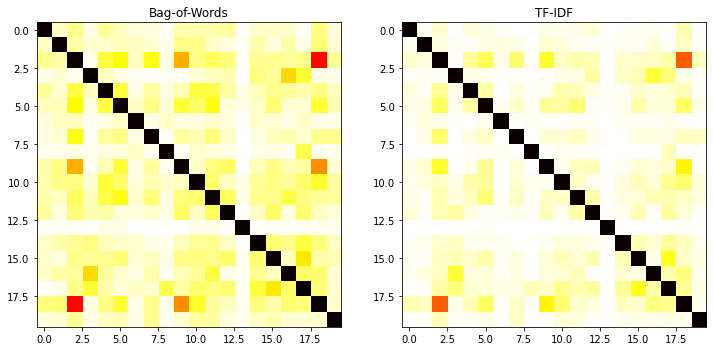

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 8))

cmap = plt.cm.get_cmap('hot')
cmap = cmap.reversed()
ax[0].imshow(bow_cosine, interpolation="nearest", cmap=cmap)
ax[0].set_title("Bag-of-Words")
ax[1].imshow(tfidf_cosine, interpolation="nearest", cmap=cmap)
ax[1].set_title("TF-IDF")
plt.show()

Guide Questions:

*Can this be used to determine playlist quality?*

* Yes, especially in that the quality of this playlist is particularly bad since the songs are 'distant' from one another. However, since our methods did not take word context into account (surrounding words or associated words), it is entirely possible that the songs are similar not strictly lexically but in theme.

*What does this say about the homogeneity of the playlist themes?*

* The heatmap shows that, with a few exceptions, the songs in this playlist are not at all similar to each other. There is great variety in the lyrics.

*What does this say about how songs (in that playlist genre) are written?*

* Songs are generally unique, blah blah blah

6. Identify the top 5 most important words for each song using TFIDF. Discuss the relationship of these words to their respective songs and analyze if they can be used as passable summaries of the songs. **2 pts** 

Make sure to remove stopwords. No need to lemmatize or stem, but is very welcome.

In [20]:
word_list = [word for word, idx in sorted(list(tfidf_vectorizer.vocabulary_.items()), key=lambda x: x[1])]

top_5_words = []
for row in tfidf_matrix:
    top_words_indices = np.argpartition(row, -5)[-5:] 
    top_5_words.append([word_list[i] for i in top_words_indices])

df = pd.DataFrame()
df['Song'] = song_titles
df['Top 5 Words'] = top_5_words
df

,Song,Top 5 Words
0,Smells Like Teen Spirit,"[entertain, how, denial, hello, low]"
1,Zombie,"[oh, ie, head, zombie, du]"
2,Under the Bridge,"[place, downtown, take, love, yeah]"
3,Killing In The Name,"[justify, fuck, ya, what, tell]"
4,Wonderwall,"[one, say, maybe, save, gonna]"
5,Enter Sandman,"[enter, exit, hand, never, land]"
6,Come As You Are,"[old, friend, gun, refrain, memoria]"
7,Bitter Sweet Symphony,"[violence, melody, change, ever, mould]"
8,Black Hole Sun,"[rain, sun, come, black, hole]"
9,Song 2,"[pin, metal, yeah, woohoo, easy]"


### Bonus:
Do a TFIDF analysis for a single artist's top 5 songs. Identify the top 10 most important words and discuss an analysis of these. **5 pts.**

**Get the top 5 songs:**

In [22]:
artist_uri = "spotify:artist:6PfSUFtkMVoDkx4MQkzOi3"
results = sp.artist_top_tracks(artist_uri)

In [53]:
top_5_tracks = [(track['name'], track['artists'][0]['name']) for track in results['tracks']][:5]
top_5_tracks

[('money machine', '100 gecs'),
 ('hand crushed by a mallet', '100 gecs'),
 ('stupid horse', '100 gecs'),
 ('ringtone', '100 gecs'),
 ('One Step Closer - 100 gecs Reanimation', 'Linkin Park')]

**Get the lyrics:**

In [56]:
artist_top5_lyrics = {}
for track, artist in top_5_tracks:
    lyrics = genius.search_song(track, artist).lyrics
    artist_top5_lyrics[track] = lyrics

Searching for "money machine" by 100 gecs...
Done.
Searching for "hand crushed by a mallet" by 100 gecs...
Done.
Searching for "stupid horse" by 100 gecs...
Done.
Searching for "ringtone" by 100 gecs...
Done.
Searching for "One Step Closer - 100 gecs Reanimation" by Linkin Park...
Done.


**Create the tf-idf matrix**

In [57]:
song_titles, lyrics = zip(*artist_top5_lyrics.items())

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

preprocessed_lyrics = preprocess(lyrics)
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_lyrics)
tfidf_matrix = tfidf_matrix.toarray()
tfidf_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.17070784],
       [0.        , 0.        , 0.        , ..., 0.05142952, 0.06374557,
        0.04269115],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01855957],
       [0.02506591, 0.02506591, 0.02506591, ..., 0.02022302, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

**Get top 10 words**

In [59]:
pd.set_option('display.max_colwidth', None)

word_list = [word for word, idx in sorted(list(tfidf_vectorizer.vocabulary_.items()), key=lambda x: x[1])]

top_10_words = []
for row in tfidf_matrix:
    top_words_indices = np.argpartition(row, -10)[-10:] 
    top_10_words.append([word_list[i] for i in top_words_indices])

df = pd.DataFrame()
df['Song'] = song_titles
df['Top 10 Words'] = top_10_words

df

,Song,Top 10 Words
0,money machine,"[yeah, oh, big, feel, like, boys, clean, come, machine, money]"
1,hand crushed by a mallet,"[want, make, fuck, copy, say, fun, go, think, inside, way]"
2,stupid horse,"[go, oh, account, fell, money, bank, lose, stupid, porsche, horse]"
3,ringtone,"[answer, sick, think, one, always, call, ringtone, boy, know, get]"
4,One Step Closer - 100 gecs Reanimation,"[everything, need, breathe, break, closer, shut, one, edge, step, say]"


Deadline **March 17 11:59PM**. Submission link to be posted in Moodle. 
Submit a .zip file containing the notebook and a 'data/' directory containing the songs with name <SURNAME>_<ID NUMBER>.ipynb.
Make sure to remove or obfuscate any API keys you include in the final submission.
    
Sample: **"BAUTISTA_110464.zip"**